## Checking out the data/images

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys,os

In [43]:
training_dir = os.path.realpath('..') + r'\chest_xray\train'
validation_dir = os.path.realpath('..') + r'\chest_xray\test'
test_dir = os.path.realpath('..') + r'\chest_xray\val'

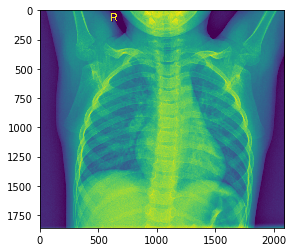

In [44]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [45]:
def plot_images(path, labeled=False, max_images=6):
    amount = 0
    fig = plt.figure(figsize=(12, 6))
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            if amount == max_images:
                break

            img = mpimg.imread(os.path.join(path, file))
            plt.subplot(231+amount)
            if labeled:
                plt.title(file.split('_')[1])
            imgplot = plt.imshow(img)

            amount += 1

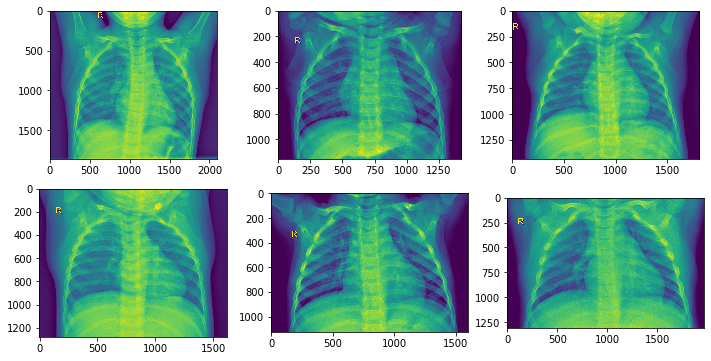

In [46]:
plot_images(training_dir + '/NORMAL')

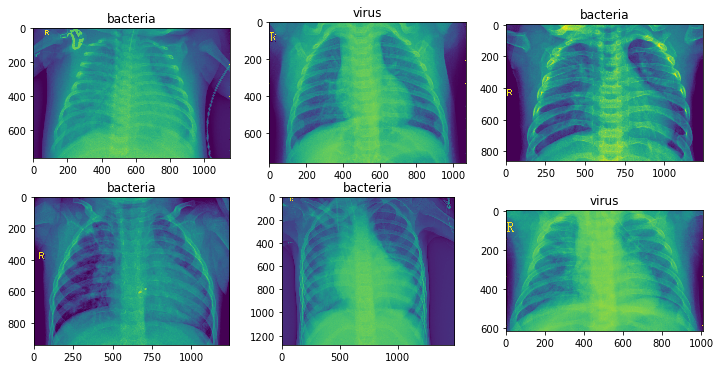

In [11]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

## Train the model

In [12]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [13]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
def get_model():
    
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    predictions = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
  
    model.summary()
    return model

In [19]:
model = get_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [21]:
model.compile(keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/5
163/163 [==============================] - 215s 1s/step - loss: 0.4580 - accuracy: 0.8489 - val_loss: 3.4663 - val_accuracy: 0.6346
Epoch 2/5
163/163 [==============================] - 372s 2s/step - loss: 0.2924 - accuracy: 0.8947 - val_loss: 2.2544 - val_accuracy: 0.5946
Epoch 3/5
163/163 [==============================] - 337s 2s/step - loss: 0.2896 - accuracy: 0.8898 - val_loss: 0.8373 - val_accuracy: 0.7244
Epoch 4/5
163/163 [==============================] - 332s 2s/step - loss: 0.2577 - accuracy: 0.8944 - val_loss: 3.5898 - val_accuracy: 0.6843
Epoch 5/5
163/163 [==============================] - 330s 2s/step - loss: 0.2507 - accuracy: 0.9028 - val_loss: 0.6108 - val_accuracy: 0.7115


## Evaluate the model

In [22]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 2s 148ms/step
Loss: 10.559176445007324
Accuracy: 0.75


In [23]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
    y_img_batch, y_true_batch = test_generator[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)

    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64)]

In [26]:
def predict_images(images_path, label):
    amount = 0
    fig = plt.figure(figsize=(18, 8))

    for file in os.listdir(images_path):
        if file.endswith('.jpeg'):
            if amount == 8:
                break

        img = mpimg.imread(os.path.join(images_path, file))
        plt.subplot(241+amount)
        plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
        imgplot = plt.imshow(img)

        amount += 1

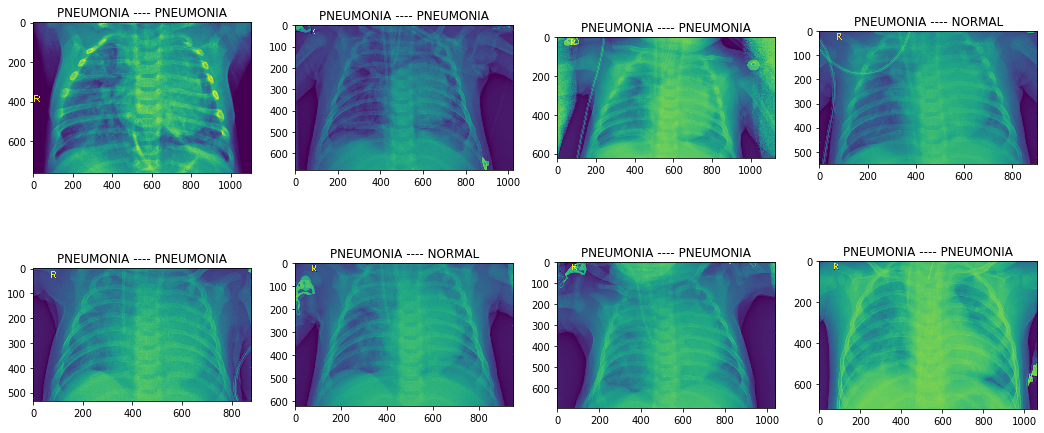

In [30]:
predict_images(validation_dir +'/PNEUMONIA', 'PNEUMONIA')

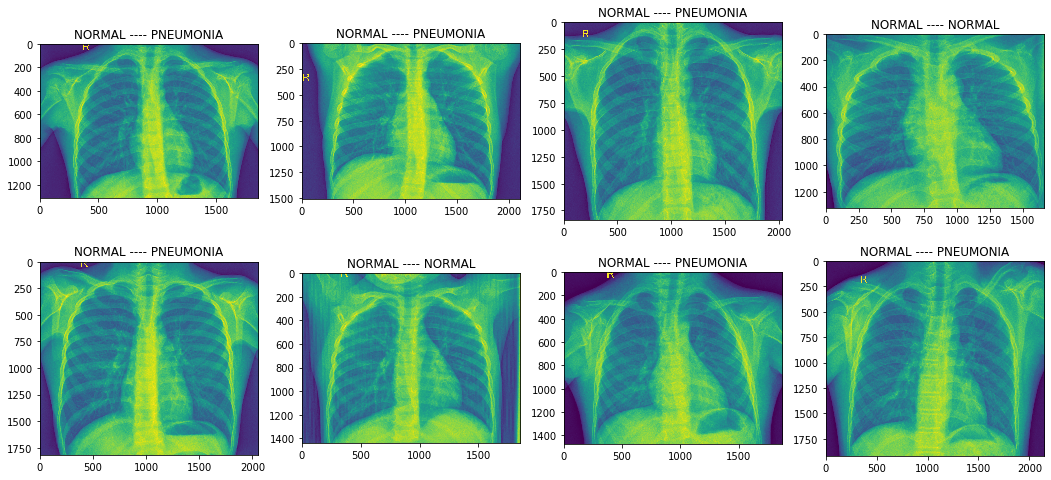

In [31]:
predict_images(validation_dir +'/NORMAL', 'NORMAL')

## Model saving and loading

In [32]:
model.save('PNEUMONIA.h5')

In [33]:
#new_model = keras.models.load_model('PNEUMONIA.h5')